In [1]:
import librosa
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D, MaxPooling2D
from keras.models import Model
import librosa
import librosa.display
import matplotlib
from keras.models import model_from_json
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint
import cv2
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [12]:
#need only once
def create_mel_spec_imagedata(song_path, save_image_path):
    for audioname in os.listdir(song_path):

        audio_path= "/home/arpita/Hw4/dataset/" + audioname #+ '.wav' #location
        y, sr= librosa.load(audio_path)   
        plt.axis('off') # no axis
        plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
        S = librosa.feature.melspectrogram(y= y , sr= sr)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.axis('off')
        plt.margins(0,0)
        name = audioname.split(".")[0]
        plt.savefig(save_image_path + name + ".png", bbox_inches=None, pad_inches=0, aspect = 'auto')
        plt.close()
    print("Saved all images at ", save_image_path)

In [14]:
#needed only once
create_mel_spec_imagedata("/home/arpita/Hw4/dataset/", "/home/arpita/Hw4/audioimages/melspec/")

/tmp/ipykernel_25613/2890448571.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "aspect" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(save_image_path + name + ".png", bbox_inches=None, pad_inches=0, aspect = 'auto')


Saved all images at  /home/arpita/Hw4/audioimages/melspec/


In [15]:
def load_imgs_dataset(path):
    img_dataset = []
    for i in range(1, 672):
        imgname = str(i) + ".png"
        img = cv2.imread(path + imgname, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_dataset.append(img)
    img_dataset = np.array(img_dataset)
    print(img_dataset.shape)
    return img_dataset

In [16]:
data_set_load = load_imgs_dataset("/home/arpita/Hw4/audioimages/melspec/")
# print(data_set_load.shape)

block_size = 72

w=data_set_load[0].shape[0]
h=data_set_load[0].shape[1]
block_data_set = []

for img in data_set_load:
    for r in range(0, w,block_size):
        for c in range(0, h, block_size):
            block_data_set.append(img[r:r+block_size,c:c+block_size]) 

block_data_set = np.array(block_data_set)
print(block_data_set.shape)

(671, 288, 432, 3)
(16104, 72, 72, 3)


In [17]:
input_img = Input(shape=(72, 72, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

extraction_model = Model(input_img, decoded)
extraction_model.compile(optimizer='adam', loss='MSE')

extraction_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 36, 36, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 18, 1)         289 

In [18]:

checkpointer = ModelCheckpoint(filepath = "/home/arpita/Hw4/Models/PR4.ckpt", 
                               monitor='loss',
                               save_best_only=True)

extraction_model.fit(block_data_set, block_data_set,
                     batch_size=64, 
                     epochs=200, 
                     callbacks=[checkpointer])

Epoch 1/200


2022-03-17 11:54:06.104806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 250449408 exceeds 10% of free system memory.
2022-03-17 11:54:06.183721: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 250449408 exceeds 10% of free system memory.


252/252 [==============================] - ETA: 0s - loss: 1678.2705

2022-03-17 11:54:59.039016: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/arpita/Hw4/Models/PR4.ckpt/assets
252/252 [==============================] - 53s 209ms/step - loss: 1678.2705
Epoch 2/200
252/252 [==============================] - 53s 209ms/step - loss: 565.3404
Epoch 3/200
252/252 [==============================] - 53s 209ms/step - loss: 466.9862
Epoch 4/200
252/252 [==============================] - 53s 209ms/step - loss: 435.9409
Epoch 5/200
252/252 [==============================] - 53s 209ms/step - loss: 412.4676
Epoch 6/200
252/252 [==============================] - 53s 209ms/step - loss: 393.9882
Epoch 7/200
252/252 [==============================] - 53s 209ms/step - loss: 385.7768
Epoch 8/200
252/252 [==============================] - 53s 209ms/step - loss: 378.8067
Epoch 9/200
252/252 [==============================] - 53s 209ms/step - loss: 366.4879
Epoch 10/200
252/252 [==============================] - 54s 214ms/step - loss: 355.0894
Epoch 11/200
252/252 [==============================] - 53s 209ms

Epoch 39/200
252/252 [==============================] - 52s 207ms/step - loss: 195.2309
Epoch 40/200
252/252 [==============================] - 53s 210ms/step - loss: 193.8867
Epoch 41/200
252/252 [==============================] - 53s 209ms/step - loss: 193.2644
Epoch 42/200
252/252 [==============================] - 53s 209ms/step - loss: 192.4863
Epoch 43/200
252/252 [==============================] - 52s 207ms/step - loss: 192.4894
Epoch 44/200
252/252 [==============================] - 52s 207ms/step - loss: 193.0762
Epoch 45/200
252/252 [==============================] - 53s 209ms/step - loss: 190.3074
Epoch 46/200
252/252 [==============================] - 52s 207ms/step - loss: 191.9273
Epoch 47/200
252/252 [==============================] - 53s 210ms/step - loss: 189.1761
Epoch 48/200
252/252 [==============================] - 52s 207ms/step - loss: 194.0154
Epoch 49/200
252/252 [==============================] - 53s 209ms/step - loss: 188.3074
Epoch 50/200
252/252 [==========

Epoch 99/200
252/252 [==============================] - 52s 206ms/step - loss: 181.8389
Epoch 100/200
252/252 [==============================] - 52s 207ms/step - loss: 180.9156
Epoch 101/200
252/252 [==============================] - 52s 207ms/step - loss: 181.2486
Epoch 102/200
252/252 [==============================] - 52s 207ms/step - loss: 181.0671
Epoch 103/200
252/252 [==============================] - 52s 207ms/step - loss: 180.5024
Epoch 104/200
252/252 [==============================] - 52s 207ms/step - loss: 182.2013
Epoch 105/200
252/252 [==============================] - 53s 209ms/step - loss: 179.7720
Epoch 106/200
252/252 [==============================] - 52s 207ms/step - loss: 182.8805
Epoch 107/200
252/252 [==============================] - 52s 207ms/step - loss: 180.2090
Epoch 108/200
252/252 [==============================] - 53s 209ms/step - loss: 179.2616
Epoch 109/200
252/252 [==============================] - 52s 207ms/step - loss: 181.2893
Epoch 110/200
252/252 

252/252 [==============================] - 53s 209ms/step - loss: 176.2397
Epoch 173/200
252/252 [==============================] - 52s 207ms/step - loss: 177.6573
Epoch 174/200
252/252 [==============================] - 52s 207ms/step - loss: 176.5997
Epoch 175/200
252/252 [==============================] - 52s 206ms/step - loss: 176.7608
Epoch 176/200
252/252 [==============================] - 52s 207ms/step - loss: 176.7134
Epoch 177/200
252/252 [==============================] - 52s 206ms/step - loss: 176.9859
Epoch 178/200
252/252 [==============================] - 52s 207ms/step - loss: 176.6104
Epoch 179/200
252/252 [==============================] - 52s 207ms/step - loss: 176.7849
Epoch 180/200
252/252 [==============================] - 52s 207ms/step - loss: 177.3524
Epoch 181/200
252/252 [==============================] - 53s 209ms/step - loss: 175.9078
Epoch 182/200
252/252 [==============================] - 52s 207ms/step - loss: 176.6744
Epoch 183/200
252/252 [============

In [19]:
encoder = Model(input_img, encoded)
extraction_model.load_weights(filepath ="/home/arpita/Hw4/Models/PR4.ckpt")

for i in range(0, len(encoder.layers)):

    extracted_weights = extraction_model.layers[i].get_weights()
    encoder.layers[i].set_weights(extracted_weights)
    print(extracted_weights)

[]
[array([[[[-1.54724193e-03, -1.37392670e-01,  1.28550962e-01,
          -1.10722154e-01,  5.16880713e-02, -3.32766920e-02,
           6.69893473e-02,  3.05990744e-02,  1.01081394e-01,
          -1.21548725e-03, -2.21346438e-01, -1.45622063e-02,
           1.92887299e-02,  9.17196423e-02, -4.21951190e-02,
          -1.51190415e-01, -1.00680567e-01,  9.40381642e-03,
           1.44940972e-01,  6.14013057e-03,  2.24242657e-02,
          -9.52666476e-02, -8.87358859e-02, -1.23804428e-01,
           1.10233046e-01,  5.78411706e-02,  4.16782983e-02,
          -1.65347219e-01, -2.02921405e-01,  1.19170494e-01,
           2.70504337e-02,  1.26402617e-01],
         [ 2.98412479e-02, -1.11886032e-01,  3.05166483e-01,
          -1.37450844e-01,  5.47980852e-02,  1.32396221e-01,
          -1.03567265e-01, -4.71817181e-02,  6.70257583e-02,
          -1.81183200e-02,  5.40815480e-02,  1.91743986e-03,
           6.73416406e-02,  2.49548983e-02, -4.11882624e-02,
           3.61634567e-02, -6.736501

2022-03-17 14:48:42.316043: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/arpita/Hw4/Models/PR4.ckpt: FAILED_PRECONDITION: /home/arpita/Hw4/Models/PR4.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [20]:
encoder_full_pred = encoder.predict(block_data_set)
print(encoder_full_pred.shape)
reduced_feature_vector = encoder_full_pred.reshape(671, 1944)
print(reduced_feature_vector.shape)
kmeans = KMeans(n_clusters=20)
kmeans.fit(reduced_feature_vector)
kmeans.cluster_centers_
clusters = kmeans.predict(reduced_feature_vector)
prediction = kmeans.labels_ + 1
print(prediction)


#DBSCAN

# db = DBSCAN(eps=0.4, min_samples=20)
# db.fit(reduced_feature_vector)


2022-03-17 14:49:55.325989: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 250449408 exceeds 10% of free system memory.


(16104, 9, 9, 1)
(671, 1944)
[ 3  6  8 15 17  9  5  9 18 16  1 13 11  3  1  6 13 18 11  2 19 15 17 14
 19  6 15 19 15 15 15  5  5 19 17 19 11 15  1 18  3 15 19 16  7  3 14 18
 19 15 20 18 13 15  7 11 13  5  4 14 17  5 13 13 10 10 14 19 16 13  3 18
  2 15 14 15  4  1 13 15  6 19 15  8  1 17  3 15  7 13 10 20  3 12 17 12
  7  6  2 18  3 19 19  7  9 11  4 20 13 19 20  3  7 13  3 10  1 15  3  4
 19 15  1 13  2 19  9 18 19  4 20 12 20  1 19 11  1 18 11 18 20 18 19 15
 14 10  3  5 17 19 19 19  9  1 13  7 12  4 13 15 13 18 19 20  1  4  1  1
  5  5  1 17 19 13 11 14  7 15 17 20  2 10 18 19  4  5 18  3 19  1  3  6
  5  3  9 19  1 10  3 19 15  2  6 16 11 13 14  1  3 19 14 15  4 11 18 17
  3  6 18  4 15 17 14 18  7 15 15  4 17  3 14 17 10 15 14 18  1  1  1 19
 18  6 17  8 18 19  3 15  1  2  1 15 13 15 20 18 18  1 19  3 15 13  3 20
  1  6 13  2 18  1 16  4 14 11 13 11 13 13  1 19  8 19  3 15  5 15 14 19
 17  3  3  5 19 14  1 15 15  1  3  5  4 11 19 19 12  4 18 18 15 19 11 16
 12 10  3  7 19 16 20 

In [21]:
filename = "/home/arpita/Hw4/Results/Prediction_file.txt"

with open(filename, 'w', newline='') as w1:
    writer = csv.writer(w1, delimiter=' ')
    for p in prediction:
        writer.writerow([p])


Text(0.5, 1.0, 'Clusters determined by KMeans')

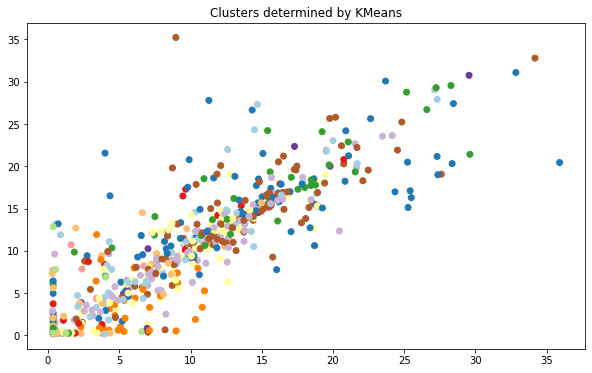

In [23]:
plt.figure(figsize=(10,6))
plt.scatter(reduced_feature_vector[:,0], reduced_feature_vector[:,1],c=clusters, cmap='Paired')
plt.title("Clusters determined by KMeans")